In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hhj01.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(626, 693, 3)


preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수입니다.  
먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리

모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고,  
OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정

전처리된 이미지는 run() 함수에서 입력값으로 사용

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

AIFFEL의 딥러닝 관련 코드는 Tensorflow V2 기준으로 작성되지만, 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델 구조를 그대로 가져와 활용하면서,

Tensorflow V2에서 V1 코드와 모델 구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용하고 있습니다.

그래서 다소 생소할 수 있는 session, graph, feed_dict 등 Tensorflow V2에서는 Model, Input 등에 감추어져 있는 구조가 위 코드에 드러나 있습니다.

사전에 학습된 가중치(pretrained weight)를 불러옵니다. 구글에서 제공하는 파일을 다운로드

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(626, 693, 3) (463, 513, 3) 15


글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 제공하는 라벨 종류는 아래와 같

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화

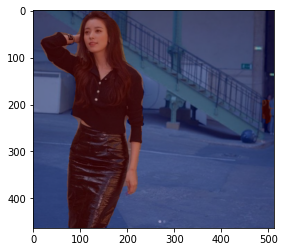

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됩니다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력

세그멘테이션 결과(mask)를 원래 크기로 복원

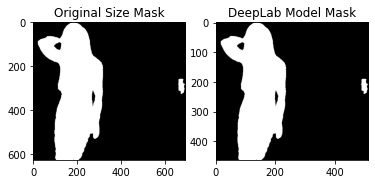

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법  
결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법

블러 함수 이용해 배경 흐리기

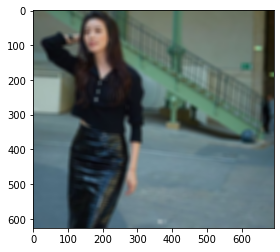

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

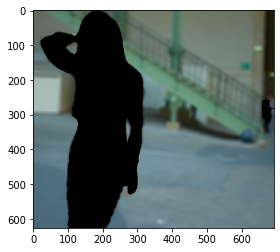

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(bitwise_not 함수를 이용하면 이미지가 반전됩니다. 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.)

사람, 배경 합치기  
세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러

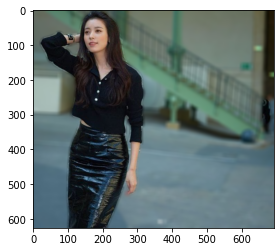

In [11]:
# 합치기1
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

두번째, 배경을 바꿔보기

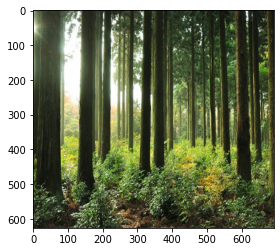

In [12]:
# 이미지 불러올 때 블러 대신 다른 이미지를
배경로 = os.getenv('HOME')+'/aiffel/human_segmentation/images/news_img_02_m.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
배경 = cv2.imread(배경로)
배경리사이즈 = cv2.resize(배경, dsize=(693, 626), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(배경리사이즈, cv2.COLOR_BGR2RGB))
plt.show()

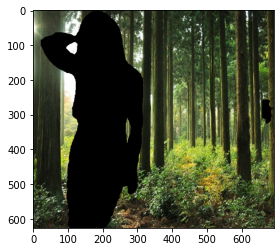

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(배경리사이즈, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

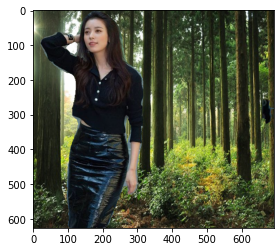

In [14]:
# 합치기2
img_concat2 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

세번째사진

(339, 509, 3)
(339, 509, 3) (341, 513, 3) 17


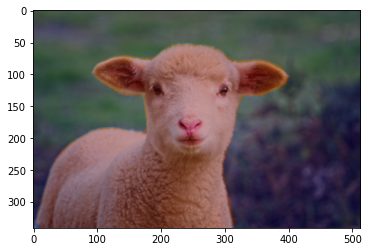

In [15]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/십새끼.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

img_show = img_resized.copy()
seg_map = np.where(seg_map == 17, 17, 0) # 예측 중 양만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

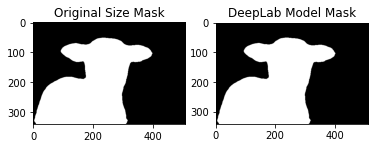

In [16]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

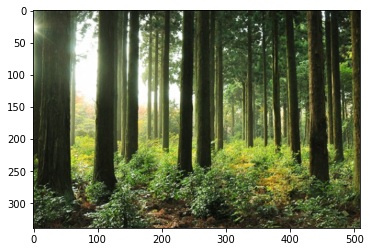

In [17]:
배경로 = os.getenv('HOME')+'/aiffel/human_segmentation/images/news_img_02_m.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
배경 = cv2.imread(배경로)
배경리사이즈 = cv2.resize(배경, dsize=(509, 339), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(배경리사이즈, cv2.COLOR_BGR2RGB))
plt.show()

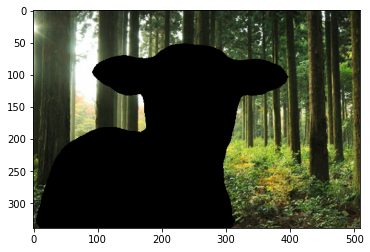

In [18]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(배경리사이즈, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

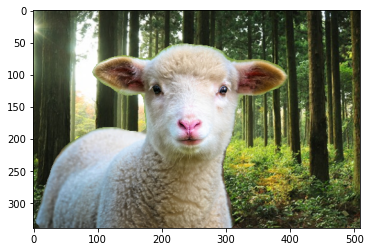

In [19]:
# 합치기3
img_concat3 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

# 2 문제점 찾기

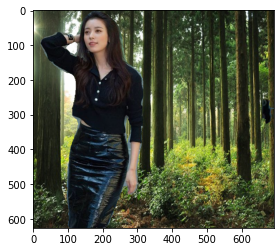

True

In [22]:
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('유령이있다.jpg', img_concat2)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


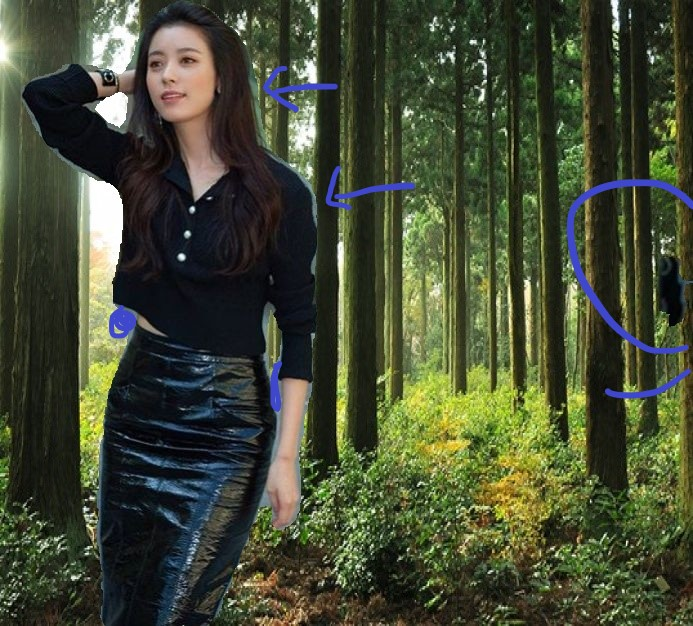

In [25]:
!pip install IPython 
from IPython.display import Image
Image("/aiffel/aiffel/human_segmentation/models/유령이있다.jpg")

아주 멀리 있는 배경같은 사람까지 사람으로 인식해버려서 까만 구멍이 생겼다.  
인물의 주변부에 경계선이 너무 굵고 특히 겹치는 부위에서 심하다.

# 3 문제점 해결하려면?

아이폰X에서부터 지문인식 대신 본인 확인 수단으로 내세운 ‘페이스ID’는 입체구조광(Structured LightㆍSL) 기술을 사용하고 있다. SL 방식은 특정한 직선이나 격자무늬와 같은 특정한 패턴의 레이저를 얼굴에 쏜 뒤, 얼굴 표면의 모양에 따라 패턴이 변형된 정도를 분석한다. 예를 들어 직선 패턴 레이저가 얼굴에 닿는다면 코끝에서는 위로 볼록한 모양을, 인중에서는 아래로 볼록한 모양을 하게 되는 것이다. 애플의 페이스ID는 점 3만개 이상을 투사하는 ‘로미오’ 센서와 이 패턴을 읽는 ‘줄리엣’ 센서의 합작품이다. AI는 대상 얼굴의 미세 질감을 계속 학습하기 때문에, 안경을 끼거나 수염이 난 모습을 보더라도 같은 사람으로 인식한다.

삼성전자 등 스마트폰 제조사들이 차세대 스마트폰에 적용하기 위해 개발하고 있는 또 다른 3D 얼굴인식 기법은 비행시간측정(Time of FlightㆍToF) 방식이라고 불린다. ToF는 레이저가 촬영 대상 표면에 닿았다가 반사돼 돌아오는 시간을 측정한 뒤 이미지 센서가 찍은 사진과 합성해 결과를 도출해낸다. 미세한 차이까지 감지할 수 있기 때문에, 속눈썹 한 올까지 인지할 수 있다. ToF는 SL 방식과 달리 상당히 멀리 떨어져 있는 대상도 인식이 가능해 한층 진화된 기술로 평가받는다.  
  
  https://www.hankookilbo.com/News/Read/201812201836781901

인물모드 사진의 문제점은 사람의 눈이 두개인 이유와도 닿아있다는 생각이 든다. 한장의 사진으로는 거리감을 느낄 수 없기 때문에 비슷한 색이면 같은 물체로 인식되고, 하나의 물체에도 갑작스레 다른 색이 나오면 다른 물체처럼 보이게 되는게 아닐지...  
그래서 기술이 발전하더라도 여전히 두대 이상의 카메라가 탑재되는 것이 더 높은 효율을 보일 것이라는 생각이 든다. 그래서 픽셀4에도 적외선 카메라가 두대나 달린거 같고. 그것도 결국은 여러대의 카메라 활용이라는 생각이다.

상세한 적용법은....... 애초에 불러오는 데이터도 여러대의 카메라로 찍혀서 거리정보가 포함된 사진들로 학습을 시키고, 이후에 다른 사진 판별에 활용해야겠다는 생각만 든다.  
모르겠어요.ㅇㅅㅇ;